<a href="https://colab.research.google.com/github/Amr-Ebrahim/Amr_Ebrahim.github.io/blob/master/K_means_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Please upload your images (you can select multiple files)...


Saving 74.jpg to 74 (1).jpg
Saving 42.jpg to 42.jpg
Saving 12.jpg to 12.jpg
Saving 6.jpg to 6 (1).jpg
Uploaded 4 files: 74 (1).jpg, 42.jpg, 12.jpg, 6 (1).jpg

Processing: 74 (1).jpg
Original Image:
--- Original: 74 (1).jpg ---


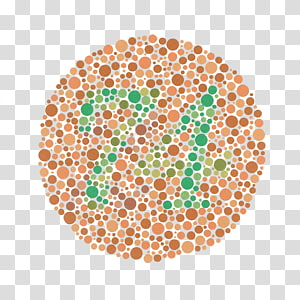

Performing K-means segmentation with 3 clusters...
Segmented Image:
--- Segmented: 74 (1).jpg ---


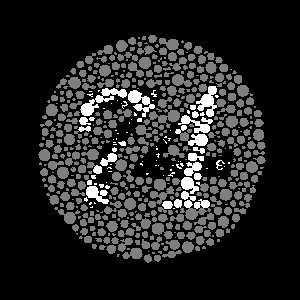

Segmented image saved to segmented_images/segmented_74 (1).jpg

Processing: 42.jpg
Original Image:
--- Original: 42.jpg ---


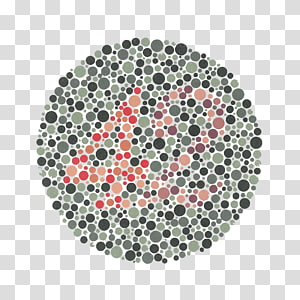

Performing K-means segmentation with 3 clusters...
Segmented Image:
--- Segmented: 42.jpg ---


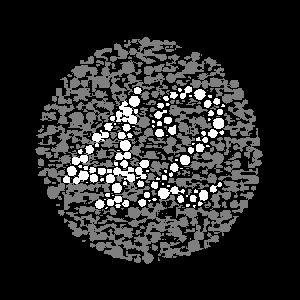

Segmented image saved to segmented_images/segmented_42.jpg

Processing: 12.jpg
Original Image:
--- Original: 12.jpg ---


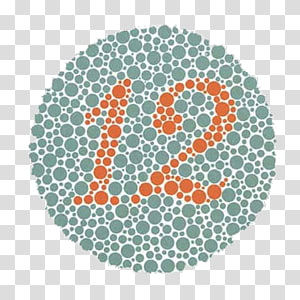

Performing K-means segmentation with 3 clusters...
Segmented Image:
--- Segmented: 12.jpg ---


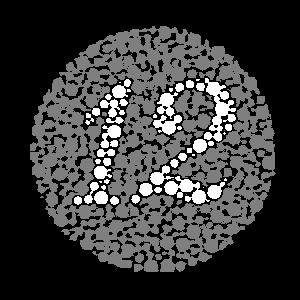

Segmented image saved to segmented_images/segmented_12.jpg

Processing: 6 (1).jpg
Original Image:
--- Original: 6 (1).jpg ---


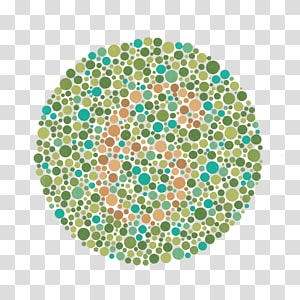

Performing K-means segmentation with 3 clusters...
Segmented Image:
--- Segmented: 6 (1).jpg ---


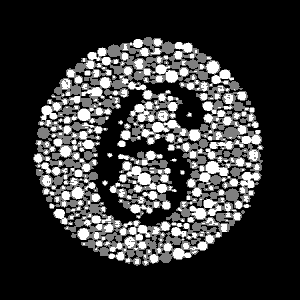

Segmented image saved to segmented_images/segmented_6 (1).jpg

--- Processing Summary ---
Successfully processed 4 images:
  - 74 (1).jpg → segmented_74 (1).jpg
  - 42.jpg → segmented_42.jpg
  - 12.jpg → segmented_12.jpg
  - 6 (1).jpg → segmented_6 (1).jpg

Creating ZIP file with all segmented images...
  adding: segmented_12.jpg (deflated 2%)
  adding: segmented_42.jpg (deflated 3%)
  adding: segmented_6 (1).jpg (deflated 3%)
  adding: segmented_74 (1).jpg (deflated 2%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for segmented_images.zip


In [4]:
import cv2
import numpy as np
from threading import Thread
from google.colab import files
import os
from google.colab.patches import cv2_imshow  # Import the Colab-compatible image display function

def assign_labels_thread(start_idx, end_idx, pixels, centroids, labels):
    """
    Multithreaded pixel-to-centroid assignment
    Args:
        start_idx: Starting index for this thread
        end_idx: Ending index for this thread
        pixels: Array of pixel values
        centroids: Current centroid positions
        labels: Array to store the assigned labels
    """
    for i in range(start_idx, end_idx):
        distances = np.linalg.norm(pixels[i] - centroids, axis=1)
        labels[i] = np.argmin(distances)

def kmeans_multithreaded(
    image, K=2, max_iters=10, color_space="Lab", channels=[1], num_threads=8
):
    """
    Perform K-means clustering on an image using multithreading for faster processing
    Args:
        image: Input image (BGR format)
        K: Number of clusters
        max_iters: Maximum number of iterations
        color_space: Color space to use ("BGR", "HSV", "Lab", "YCbCr")
        channels: List of channels to use for clustering
        num_threads: Number of threads to use for parallel processing
    Returns:
        segmented: Segmented image as grayscale
    """
    # Color space conversions
    if color_space == "HSV":
        image_cs = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == "Lab":
        image_cs = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    elif color_space == "YCbCr":
        image_cs = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else:
        image_cs = image.copy()

    # Extract selected channels
    img_data = image_cs[:, :, channels]
    pixels = img_data.reshape(-1, len(channels)).astype(np.float32)

    # Initialize centroids randomly
    np.random.seed(42)
    centroids = pixels[np.random.choice(len(pixels), K, replace=False)]
    labels = np.zeros(len(pixels), dtype=np.int32)

    for _ in range(max_iters):
        # Assign labels with multithreading for faster processing
        num_threads = num_threads
        chunk_size = len(pixels) // num_threads
        threads = []

        for t in range(num_threads):
            start = t * chunk_size
            end = len(pixels) if t == num_threads - 1 else (t + 1) * chunk_size
            thread = Thread(
                target=assign_labels_thread,
                args=(start, end, pixels, centroids, labels),
            )
            thread.start()
            threads.append(thread)

        for thread in threads:
            thread.join()

        # Update centroids
        for k in range(K):
            cluster_points = pixels[labels == k]
            if len(cluster_points) > 0:
                centroids[k] = np.mean(cluster_points, axis=0)

    segmented = labels.reshape(image.shape[:2])

    # Map clusters to grayscale intensities
    unique_labels, counts = np.unique(segmented, return_counts=True)
    sorted_indices = np.argsort(-counts)
    grayscale_map = np.zeros(K, dtype=np.uint8)

    for i, idx in enumerate(sorted_indices):
        grayscale_map[idx] = int(255 * (i / (K - 1))) if K > 1 else 255

    final_image = np.zeros_like(segmented, dtype=np.uint8)
    for k in range(K):
        final_image[segmented == k] = grayscale_map[k]

    return final_image

def load_image(image_path):
    """
    Load an image from the specified path
    Args:
        image_path: Path to the image file
    Returns:
        image: Loaded image in BGR format
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from {image_path}")
    return image

def display_image(image, window_name="Image"):
    """
    Display an image in Google Colab
    Args:
        image: Image to display
        window_name: Name for the display window
    """
    # For Google Colab, we use cv2_imshow and print the window name
    print(f"--- {window_name} ---")
    cv2_imshow(image)
    # No need for waitKey or destroyAllWindows in Colab

def save_image(image, output_path):
    """
    Save an image to the specified path
    Args:
        image: Image to save
        output_path: Path where the image will be saved
    Returns:
        success: Boolean indicating if the save was successful
    """
    return cv2.imwrite(output_path, image)

# For Google Colab file upload
from google.colab import files

# Upload multiple images
print("Please upload your images (you can select multiple files)...")
uploaded = files.upload()
uploaded_filenames = list(uploaded.keys())
print(f"Uploaded {len(uploaded_filenames)} files: {', '.join(uploaded_filenames)}")

# Configuration
K_CLUSTERS = 3  # Number of clusters for segmentation
MAX_ITERATIONS = 10  # Maximum iterations for K-means
COLOR_SPACE = "Lab"  # Color space to use
CHANNELS = [1]  # Channels to use for clustering (e.g., [1] for 'a' channel in Lab)
NUM_THREADS = 8  # Number of threads for parallel processing
OUTPUT_DIR = "segmented_images"  # Directory to save output images

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def process_image(input_filename):
    """
    Process a single image with K-means segmentation
    Args:
        input_filename: Filename of the input image
    Returns:
        success: Boolean indicating if processing was successful
    """
    try:
        # Generate output filename
        output_filename = os.path.join(OUTPUT_DIR, "segmented_" + input_filename)

        # Load the image
        print(f"\nProcessing: {input_filename}")
        image = load_image(input_filename)

        # Display original image
        print("Original Image:")
        display_image(image, f"Original: {input_filename}")

        # Perform k-means segmentation
        print(f"Performing K-means segmentation with {K_CLUSTERS} clusters...")
        segmented = kmeans_multithreaded(
            image,
            K=K_CLUSTERS,
            max_iters=MAX_ITERATIONS,
            color_space=COLOR_SPACE,
            channels=CHANNELS,
            num_threads=NUM_THREADS,
        )

        # Display the result
        print("Segmented Image:")
        display_image(segmented, f"Segmented: {input_filename}")

        # Save the result
        save_image(segmented, output_filename)
        print(f"Segmented image saved to {output_filename}")

        return True
    except Exception as e:
        print(f"Error processing {input_filename}: {str(e)}")
        return False

def main():
    successful_files = []
    failed_files = []

    # Process each uploaded image
    for filename in uploaded_filenames:
        if process_image(filename):
            successful_files.append(filename)
        else:
            failed_files.append(filename)

    # Summary
    print("\n--- Processing Summary ---")
    print(f"Successfully processed {len(successful_files)} images:")
    for f in successful_files:
        print(f"  - {f} → segmented_{f}")

    if failed_files:
        print(f"\nFailed to process {len(failed_files)} images:")
        for f in failed_files:
            print(f"  - {f}")

    # Download all segmented images as a zip file
    if successful_files:
        print("\nCreating ZIP file with all segmented images...")
        zip_filename = "segmented_images.zip"
        !zip -j {zip_filename} {OUTPUT_DIR}/*
        files.download(zip_filename)
        print(f"Download initiated for {zip_filename}")

if __name__ == "__main__":
    main()